In [ ]:
#Import all required packages
import pandas as pd
import numpy as np
import pathlib
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
import warnings
import glob
from scipy import signal
from tensorflow.keras.applications import VGG16
from tensorflow.keras import Input
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.vgg16 import preprocess_input


In [ ]:
#Read audio classification file and clean
audio_class_df = pd.read_csv("audioclassification_meta.csv")
c_names = audio_class_df.columns.tolist()
c_names = c_names[0].replace(" ", "_").split("\t")

audio_class_df[c_names] = audio_class_df['VoxCeleb1 ID\tVGGFace1 ID\tGender\tNationality\tSet'].\
                        str.split("\t", expand = True)
audio_class_df = audio_class_df[c_names]

#Set as dictionary
audio_class_dict = audio_class_df.set_index("VoxCeleb1_ID").T.to_dict('list')

#View data
audio_class_df.head()

,VoxCeleb1_ID,VGGFace1_ID,Gender,Nationality,Set
0,id10001,A.J._Buckley,m,Ireland,dev
1,id10002,A.R._Rahman,m,India,dev
2,id10003,Aamir_Khan,m,India,dev
3,id10004,Aaron_Tveit,m,USA,dev
4,id10005,Aaron_Yoo,m,USA,dev


In [ ]:
phoible_df = pd.read_csv("phoible.csv")

# Generate a mapping from nationality to language spoken
nationalities_to_language = {'Irish': 'English',
                             'India': 'Hindi', 
                             'USA': 'English (American)',
                             'Australia': 'English (Australian)',
                             'Canada': 'English', 
                             'UK': 'English (British)', 
                             'Norway': 'Norwegian',
                             'Italy': 'Italian',
                             'Sudan': 'Arabic',
                             'Mexico': 'Spanish',
                             'China': 'Standard Chinese; Mandarin',
                             'Switzerland': 'Swiss German',
                             'Guyana': 'English',
                             'Philippines':'Filipino',
                             'New Zealand': 'English (New Zealand)',
                             'Germany': 'German', 
                             'Portugal': 'Portuguese (European)',
                             'Netherlands': 'Dutch',
                             'Pakistan': 'Urdu',
                             'Croatia': 'Croatian',
                             'South Korea': 'Korean',
                             'Sweden': 'Swedish',
                             'Russia': 'Russian',
                             'Poland': 'Polish',
                             'Sri Lanka': 'Sinhalese', 
                             'Singapore': 'Mandarin Chinese',
                             'Chile': 'Spanish',
                             'Spain': 'Spanish',
                             'Israel':'Modern Hebrew',
                             'Brazil': 'Portuguese (Brazilian)',
                             'Trinidad and Tobago': 'English', 
                             'Denmark': 'Danish',
                             'Austria': 'German', 
                             'South Africa': 'English', 
                             'Iran': 'Farsi'} 

# Filter dataframe to only nationalities that will be encountered
phoible_df = phoible_df[phoible_df['LanguageName'].isin(list(nationalities_to_language.values()))]

# Find all languages spoken within VoxCeleb
all_languages = list(phoible_df['LanguageName'].unique())

# Define a mapping from language to phoneme 
# Key is language and value is a set of phonemes within that language
phonemes_per_lang = {}
for j in range(len(all_languages)):
    phonemes_per_lang[all_languages[j]] = {}
    phonemes_in_lang = phoible_df[phoible_df['LanguageName'] == all_languages[j]]['Phoneme'].unique()
    phonemes_per_lang[all_languages[j]] = set()
    for i in range(len(phonemes_in_lang)):
        phonemes_per_lang[all_languages[j]].add(phonemes_in_lang[i])

# Create a set of all the phonemes in English languages
eng_langs = ['English', 'English (American)','English (Australian)', \
             'English (British)', 'English (New Zealand)']
english_phonemes = set()
for lang in eng_langs:
    english_phonemes.update(phonemes_per_lang[lang])

# Define a mapping from English phonemes to allophones that may be present in tother languages
english_phonemes_to_allophones = {}
for phoneme in english_phonemes:
    english_phonemes_to_allophones[phoneme] = set(phoneme)                               
    for allophones in phoible_df[(phoible_df['Phoneme'] == phoneme) & (phoible_df['LanguageName'].isin(eng_langs))].Allophones:
        if pd.isnull(allophones) == False and allophones.isalnum():
            for allophone in allophones:
                english_phonemes_to_allophones[phoneme].add(allophone)

def get_key_english_phonemes_to_allophones(val):
    '''
    Function: Find English allophones of non-English phonemes
    Inputs: 
        - val: a phoneme
    Outputs:
        - key: the allophone that phoneme is known as in English, if applicable
    '''
    for key, value in english_phonemes_to_allophones.items():
        if val in value:
            return key

# Define phonemes that will be unseen in training as they are non-English and 
# remove them from a language's phoneme set, replaced by an unseen tag
for language in phonemes_per_lang:
    unseen_phonemes = set()
    for phoneme in phonemes_per_lang[language]:
        if phoneme not in english_phonemes:
            unseen_phonemes.add(phoneme) 
    for unseen_phoneme in unseen_phonemes:
        phonemes_per_lang[language].remove(unseen_phoneme)
        possible_allophone = get_key_english_phonemes_to_allophones(unseen_phoneme)
        if possible_allophone is not None:
            phonemes_per_lang[language].add(possible_allophone)
        else:
            phonemes_per_lang[language].add('unseen')

# Bypass languages to map directly from nationality to phoneme
nationalities_to_phonemes = {}
for nationality in nationalities_to_language.keys():
    nationalities_to_phonemes[nationality] = \
    phonemes_per_lang[nationalities_to_language[nationality]]


phonemes_per_lang = {}
for j in range(len(all_languages)):
    phonemes_per_lang[all_languages[j]] = {}
    phonemes_in_lang = phoible_df[phoible_df['LanguageName'] == all_languages[j]]['Phoneme'].unique()
    phonemes_per_lang[all_languages[j]] = set()
    for i in range(len(phonemes_in_lang)):
        phonemes_per_lang[all_languages[j]].add(phonemes_in_lang[i])

english_phonemes_to_allophones = {}
eng_langs = ['English', 'English (American)','English (Australian)', \
             'English (British)', 'English (New Zealand)']
english_phonemes = set()
for lang in eng_langs:
    english_phonemes.update(phonemes_per_lang[lang])

for phoneme in english_phonemes:
    english_phonemes_to_allophones[phoneme] = set(phoneme)                               
    for allophones in phoible_df[(phoible_df['Phoneme'] == phoneme) & (phoible_df['LanguageName'].isin(eng_langs))].Allophones:
        if pd.isnull(allophones) == False and allophones.isalnum():
            for allophone in allophones:
                english_phonemes_to_allophones[phoneme].add(allophone)

# Function to that provides phoneme and allophone is stored as
def get_key_english_phonemes_to_allophones(val):
    for key, value in english_phonemes_to_allophones.items():
        if val in value:
            return key

for language in phonemes_per_lang:
    unseen_phonemes = set()
    for phoneme in phonemes_per_lang[language]:
        if phoneme not in english_phonemes:
            unseen_phonemes.add(phoneme) 
    for unseen_phoneme in unseen_phonemes:
        phonemes_per_lang[language].remove(unseen_phoneme)
        possible_allophone = get_key_english_phonemes_to_allophones(unseen_phoneme)
        if possible_allophone is not None:
            phonemes_per_lang[language].add(possible_allophone)
        else:
            phonemes_per_lang[language].add('unseen')

nationalities_to_phonemes = {}
for nationality in nationalities_to_language.keys():
    nationalities_to_phonemes[nationality] = \
    phonemes_per_lang[nationalities_to_language[nationality]]

def pull_id_npz(file_name):
    '''
    Function: Load in files in npz format that are stored as dictionaries
    Inputs: 
        - file_name: string of file name containing path to file
    Outputs:
        - container_list: nested list containing values in the npz files
    '''
    container_list = []
    container = np.load(file_name,allow_pickle=True)
    container_list.append([container[key] for key in container])
    return container_list

def pull_id_npz_list(file_name):
    '''
    Function: Load in files in npz format that are stored as lists
    Inputs: 
        - file_name: string of file name containing path to file
    Outputs:
        - container_array: nested array containing values in the npz files
    '''  
    container_list = []
    container = np.load(file_name,allow_pickle=True)
    container_list.append([item for item in container])
    return np.asarray(container_list)

# Define all the nationalities, English speaking nationalities, and non English speaking nationalities
all_nationalities = list(audio_class_df['Nationality'].unique())
eng_nationalities =  ['USA', 'UK', 'Australia', 'Canada', 'New Zealand', 'Ireland', 'South Africa', 'Trinidad and Tobago', 'Guyana']
non_eng_nationalities = [nationality for nationality in all_nationalities if nationality not in eng_nationalities]

# Add the unseen tag to the set of English phonemes and define the number of classes for the LSTM model
english_phonemes.add('unseen')
n_classes = len(english_phonemes)
n_classes

/Users/ariellestern/anaconda2/envs/py36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (4,7,8,11) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


92

In [ ]:
# Load in spectrograms and phonemes for training
X_train = pull_id_npz('X_train_spec.npz')
X_train = X_train[0]

y_train_phonemes =  pull_id_npz('y_train_phonemes_no_corrupt.npz')
y_train_phonemes = y_train_phonemes[0]

In [ ]:
# Convert to array
X_train_arr = np.asarray(X_train)
y_train_phonemes_arr = np.asarray(y_train_phonemes)
del X_train

In [ ]:
from sklearn.model_selection import train_test_split
# Split data into training and validation set
X_train_arr, X_valid_arr, y_train_phonemes_arr, y_valid_phonemes_arr = \
train_test_split(X_train_arr, y_train_phonemes_arr, test_size=0.5, random_state=42) 

In [ ]:
# Stack spectrograms along 4th dimension - VGG expects the 4th dimension to have size at least 3
X_train_arr_stacked = np.stack((X_train_arr, X_train_arr, X_train_arr), axis=-1)
del X_train_arr

In [ ]:
def one_hot_encode_phonemes(y_phoneme_sets, all_phonemes_list):
    '''
    Function: One hot encode a set of phonemes
    Inputs: 
        - y_phoneme_sets: a list of sets, each of which contains the phonemes present in a given instance
        - all_phonemes_list: a list of all the possible phonemes present, generally a list of English phonemes
    Outputs:
        - y_phonemes_encoded: nested list containing encodings of phoneme sets
    '''    
    num_phonemes = len(all_phonemes_list)
    y_phonemes_encoded = []
    for example in y_phoneme_sets:
        y_phonemes_example_encoded = [0]*num_phonemes
        for i in range(len(all_phonemes_list)):
            if all_phonemes_list[i] in example.item():
                y_phonemes_example_encoded[i] = 1
        y_phonemes_encoded.append(y_phonemes_example_encoded)
    return y_phonemes_encoded


def un_one_hot_encode_phonemes(y_phoneme_encoded, all_phonemes_list):
    '''
    Function: Reverse one hot encode a set of phonemes
    Inputs: 
        - y_phoneme_encoded: a nested list, contains the phonemes present in a given instance as a one hot encoding
        - all_phonemes_list: a list of all the possible phonemes present, generally a list of English phonemes
    Outputs:
        - y_phonemes_unencoded: a list of sets, each of which contains the phonemes present in a given instance
    '''  
    num_phonemes = len(all_phonemes_list)
    y_phonemes_unencoded = []
    for example in y_phoneme_encoded:
        y_phonemes_example_unencoded = set()
        for i in range(num_phonemes):
            if example[i] == 1:
                y_phonemes_example_unencoded.add(all_phonemes_list[i])
        y_phonemes_unencoded.append(y_phonemes_example_unencoded)
    return y_phonemes_unencoded

In [ ]:
#One hot encode english phonemes
all_phonemes = list(english_phonemes)
y_train_phonemes_arr = one_hot_encode_phonemes(y_train_phonemes_arr, all_phonemes)
y_train_phonemes_arr = np.asarray(y_train_phonemes_arr)

In [ ]:
# Load in VGG model and specify new input and output sizes
new_input = Input(shape=(X_train_arr_stacked.shape[1], X_train_arr_stacked.shape[2], X_train_arr_stacked.shape[3]))
vgg_model = VGG16(include_top=False, input_tensor=new_input, classes = 92)
# Make layers not trainable 
for l in vgg_model.layers:
    l.trainable = False
# Add a dense output layer with softmax activation
pool1 = layers.MaxPooling2D()(vgg_model.layers[-1].output)
flat1 = layers.Flatten()(pool1)
output = layers.Dense(n_classes, activation='softmax')(flat1)
# define new model
vgg_model_output = Model(inputs=vgg_model.inputs, outputs=output)
vgg_model_output.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        [(None, 200, 126, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 126, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 126, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 63, 64)       0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 63, 128)      73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 63, 128)      147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 50, 31, 128)       0   

In [ ]:
from tensorflow.keras import optimizers

# Define Adam optimizer with lr = 0.01
opt = optimizers.Adam(learning_rate=0.01) 
# Compile model with binary crossentropy loss, commonly used for multilabel classification
vgg_model_output.compile(loss='binary_crossentropy', optimizer=opt)

# Process input images in the same way as VGG input images were processed
prepared_images = preprocess_input(X_train_arr_stacked)

In [ ]:
from tensorflow import config
# Fit the model to the training data, 
# NOTE: This takes about 10 hours for 10 epochs
history = vgg_model_output.fit(prepared_images, y_train_phonemes_arr,
                    epochs=10,
                    batch_size=64,
                    validation_split=0.1)

Epoch 1/10
174/174 [==============================] - 1715s 10s/step - loss: 0.4349 - val_loss: 0.3441
Epoch 2/10
174/174 [==============================] - 1739s 10s/step - loss: 0.3456 - val_loss: 0.3421
Epoch 3/10
174/174 [==============================] - 1495s 9s/step - loss: 0.3472 - val_loss: 0.3405
Epoch 4/10
174/174 [==============================] - 1412s 8s/step - loss: 0.3459 - val_loss: 0.3602
Epoch 5/10
174/174 [==============================] - 1420s 8s/step - loss: 0.3483 - val_loss: 0.3465
Epoch 6/10
174/174 [==============================] - 1378s 8s/step - loss: 0.3471 - val_loss: 0.3406
Epoch 7/10
174/174 [==============================] - 1374s 8s/step - loss: 0.3455 - val_loss: 0.3448
Epoch 8/10
174/174 [==============================] - 1374s 8s/step - loss: 0.3461 - val_loss: 0.3475
Epoch 9/10
174/174 [==============================] - 1376s 8s/step - loss: 0.3492 - val_loss: 0.3447
Epoch 10/10
174/174 [==============================] - 1375s 8s/step - loss: 0.3

In [ ]:
# Save model
vgg_model_output.save_weights('trained_cnn_audio_to_phon')
model_json = vgg_model_output.to_json()
with open('model_cnn_phon.json', "w") as json_file:
    json_file.write(model_json)
json_file.close()

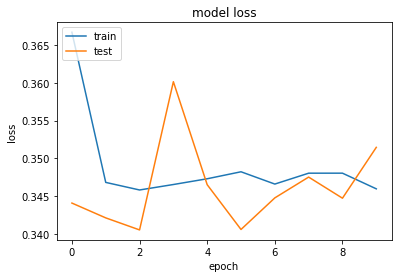

In [ ]:
# Plot training and testing loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# Stack validation arrays
X_valid_arr_stacked = np.stack((X_valid_arr, X_valid_arr, X_valid_arr), axis=-1)

In [ ]:
# Encode phonemes
y_valid_phonemes_arr = one_hot_encode_phonemes(y_valid_phonemes_arr, all_phonemes)
y_valid_phonemes_arr = np.asarray(y_valid_phonemes_arr)

In [ ]:
# Preprocess validation images
prepared_images_valid = preprocess_input(X_valid_arr_stacked)

In [ ]:
# Make predictions on validation set
valid_predictions = vgg_model_output.predict(prepared_images_valid)

In [ ]:
#Prepare test data
X_test = pull_id_npz('X_test_spec.npz')
X_test = X_test[0]
X_test_arr = np.asarray(X_test)
del X_test
X_test_arr_stacked = np.stack((X_test_arr, X_test_arr, X_test_arr), axis=-1)
prepared_images_test = preprocess_input(X_test_arr_stacked)

In [ ]:
#Predict on test data
test_predictions = vgg_model_output.predict(prepared_images_test)

In [ ]:
#Obtain y labels for test data nationalities
y_test_nationalities = pull_id_npz('y_test_nationalities.npz')
y_test_nationalities = y_test_nationalities[0]
y_test_nationalities_list = [l.tolist() for l in y_test_nationalities]

In [ ]:
#Delete all nationalities not in test data
test_nationalities_phonemes = {}

for key in nationalities_to_phonemes:
    if key in all_nationalities:
        test_nationalities_phonemes[key] = nationalities_to_phonemes[key]

del test_nationalities_phonemes['USA']
del test_nationalities_phonemes['Australia']
del test_nationalities_phonemes['Canada']
del test_nationalities_phonemes['UK']
del test_nationalities_phonemes['New Zealand']

In [ ]:
from sklearn.tree import DecisionTreeClassifier
features = [str(i) for i in range(1)]
test_predictions_thresholded = test_predictions.copy()
# Build decision tree for thresholding 
for counter, j in enumerate(valid_predictions[0]):
    X = valid_predictions[:, counter]
    X = X.reshape((X.shape[0], 1))
    y = y_valid_phonemes_arr[:, counter]
    y = y.reshape((y.shape[0], 1))
    test = test_predictions[:, counter]
    test = test.reshape((test.shape[0], 1))
    dt = DecisionTreeClassifier()
    dt.fit(X,y)
    dt_pred =dt.predict(test)
    test_predictions_thresholded[:, counter] = dt_pred
    test_predictions_thresholded[:, counter][test_predictions_thresholded[:, counter] == -1] = 0
# Convert one hot encoded phoneme predictions to set of phonemes per example
test_predictions_unencoded = un_one_hot_encode_phonemes(test_predictions_thresholded, all_phonemes)

In [ ]:
def make_predictions_overlap(nationalities_to_phonemes, y_phonemes):
    '''
    Function: Determine most likely nationality by maximizing Jaccard Index between predicted phonemes and 
    phonemes associated with each nationality
    Inputs: 
        - nationalities_to_phonemes: a mapping from nationalities to a set of associated phonemes
        - y_phonemes: list of predicted phonemes, each instance in list is a set of phonemes
    Outputs:
        - preds: list of most likely nationality for each instance 
        - all_preds - list of dictionaries containing Jaccard Index scores for each nationality for each index 
    '''
    preds = []
    all_preds = []
    for instance in y_phonemes:
        nationality_overlap = {}
        num_phonemes_in_instance = len(instance)
        for nationality in nationalities_to_phonemes:
            phoneme_overlap_count = 0
            num_phonemes_for_nationality = len(nationalities_to_phonemes[nationality])
            overlap = len(instance.intersection(nationalities_to_phonemes[nationality]))
            jaccard_index = overlap/(num_phonemes_in_instance+num_phonemes_for_nationality-overlap)
            nationality_overlap[nationality] = jaccard_index
        top_guess = max(nationality_overlap, key=nationality_overlap.get)
        preds.append(top_guess) 
        all_preds.append(nationality_overlap)
    return preds, all_preds

In [ ]:
# Generate nationality predictions on test data
y_test_nationalities_pred, confs = make_predictions_overlap(test_nationalities_phonemes, test_predictions_unencoded)

In [ ]:
def determine_accuracy_by_nationality(y_test_nationalities_list, y_test_nationalities_pred):
    '''
    Function: Determine accuracy in predicting nationality for each nationality
    Inputs: 
        - y_test_nationalities_list: list of true nationalities
        - y_test_nationalities_pred: list of predicted nationalities
    Outputs:
        - acc_per_nationality_dict: dictionary of accuracy per nationality, keys are nationalities
    '''    
    correct_count_per_nationality_dict = {}
    tot_count_per_nationality_dict = {}

    for nationality in y_test_nationalities_list:
        correct_count_per_nationality_dict[nationality] = 0
        tot_count_per_nationality_dict[nationality] = 0

    for i in range(len(y_test_nationalities_list)):
        tot_count_per_nationality_dict[y_test_nationalities_list[i]] += 1
        if y_test_nationalities_list[i] == y_test_nationalities_pred[i]:
            correct_count_per_nationality_dict[y_test_nationalities_list[i]] += 1 
    acc_per_nationality_dict = {}
    for nationality in tot_count_per_nationality_dict.keys():
        acc_per_nationality_dict[nationality] = \
        correct_count_per_nationality_dict[nationality]/tot_count_per_nationality_dict[nationality]

    return acc_per_nationality_dict



In [ ]:
# Get CNN accuracy by nationality
determine_accuracy_by_nationality(y_test_nationalities_list, y_test_nationalities_pred)

{'India': 0.001345119139123751,
 'Norway': 0.0,
 'Italy': 0.0,
 'Sudan': 0.0,
 'Mexico': 0.0,
 'China': 0.0,
 'Switzerland': 0.0,
 'Philippines': 0.0,
 'Portugal': 0.0,
 'Netherlands': 0.0,
 'Pakistan': 0.0,
 'Croatia': 0.0,
 'South Korea': 0.0,
 'Sweden': 0.0,
 'Russia': 0.0015220700152207,
 'Poland': 0.0,
 'Sri Lanka': 0.0,
 'Singapore': 0.0,
 'Chile': 0.0,
 'Spain': 0.0,
 'Israel': 1.0,
 'Brazil': 0.0,
 'Denmark': 0.0,
 'Austria': 0.0,
 'Iran': 0.0}

In [ ]:
# Get overall accuracy
from sklearn.metrics import accuracy_score
accuracy_score(y_test_nationalities_list, y_test_nationalities_pred)